<a href="https://colab.research.google.com/github/glaria/TFM/blob/main/marketing_groups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class MarketingAnalyzer:
    def __init__(self, data: pd.DataFrame):
        """
        Initialize the MarketingAnalyzer with campaign data
        """
        self.data = data.copy()
        self.segment_columns = []
        self.kpi_columns = []

    def set_analysis_columns(self, segment_columns: List[str], kpi_columns: List[str]):
        """
        Set the columns to be used for segmentation and KPI analysis
        """
        self.segment_columns = segment_columns
        self.kpi_columns = kpi_columns

    def calculate_significance(self, target_data: pd.Series, control_data: pd.Series) -> Dict:
        """
        Calculate statistical significance using two-proportion z-test with error handling
        """
        # Check for empty groups
        n1 = len(target_data)
        n2 = len(control_data)

        if n1 == 0 or n2 == 0:
            return {
                'z_statistic': np.nan,
                'p_value': np.nan,
                'is_significant': False,
                'error': 'Insufficient data in target or control group'
            }

        # Calculate proportions
        p1 = target_data.mean() if n1 > 0 else 0
        p2 = control_data.mean() if n2 > 0 else 0

        # Calculate pooled proportion
        total_successes = target_data.sum() + control_data.sum()
        total_samples = n1 + n2

        if total_samples == 0:
            return {
                'z_statistic': np.nan,
                'p_value': np.nan,
                'is_significant': False,
                'error': 'No samples available'
            }

        p_pooled = total_successes / total_samples

        # Handle case where p_pooled is 0 or 1
        if p_pooled == 0 or p_pooled == 1:
            return {
                'z_statistic': np.nan,
                'p_value': np.nan,
                'is_significant': False,
                'error': 'Unable to compute significance (p_pooled is 0 or 1)'
            }

        try:
            # Calculate standard error
            se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))

            # Calculate z-statistic
            z_stat = (p1 - p2) / se if se != 0 else 0

            # Calculate two-tailed p-value
            p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

            return {
                'z_statistic': z_stat,
                'p_value': p_value,
                'is_significant': p_value < 0.05,
                'error': None
            }
        except Exception as e:
            return {
                'z_statistic': np.nan,
                'p_value': np.nan,
                'is_significant': False,
                'error': f'Error in calculation: {str(e)}'
            }

    def calculate_lift(self, segment_def: Dict[str, str] = None) -> pd.DataFrame:
        """
        Calculate lift and statistical significance for each KPI
        """
        # Filter data for segment if specified
        data = self.data
        if segment_def:
            for col, value in segment_def.items():
                data = data[data[col] == value]

        results = []
        for kpi in self.kpi_columns:
            target_data = data[data['TGCG'] == 'TARGET'][kpi]
            control_data = data[data['TGCG'] == 'CONTROL'][kpi]

            # Handle empty groups
            target_mean = target_data.mean() if len(target_data) > 0 else np.nan
            control_mean = control_data.mean() if len(control_data) > 0 else np.nan

            # Calculate lift with error handling
            if pd.isna(target_mean) or pd.isna(control_mean) or control_mean == 0:
                lift = np.nan
            else:
                lift = ((target_mean - control_mean) / control_mean) * 100

            # Calculate significance
            significance_results = self.calculate_significance(target_data, control_data)

            results.append({
                'KPI': kpi,
                'Target_Mean': target_mean,
                'Control_Mean': control_mean,
                'Lift_Percentage': lift,
                'Z_Statistic': significance_results['z_statistic'],
                'P_Value': significance_results['p_value'],
                'Is_Significant': significance_results['is_significant'],
                'Error': significance_results['error']
            })

        return pd.DataFrame(results)

    def analyze_segments(self, kpi: str) -> pd.DataFrame:
        """
        Analyze the effectiveness of different segment combinations
        """
        results = []

        for col in self.segment_columns:
            segments = self.data[col].unique()

            for segment_value in segments:
                segment_def = {col: segment_value}
                lift_analysis = self.calculate_lift(segment_def)

                # Get results for specific KPI
                if lift_analysis.empty:
                    continue

                kpi_results = lift_analysis[lift_analysis['KPI'] == kpi].iloc[0]

                # Only add segments with valid results
                if not pd.isna(kpi_results['Lift_Percentage']):
                    results.append({
                        'Segment_Column': col,
                        'Segment_Value': segment_value,
                        'Sample_Size': len(self.data[self.data[col] == segment_value]),
                        'Lift_Percentage': kpi_results['Lift_Percentage'],
                        'Z_Statistic': kpi_results['Z_Statistic'],
                        'P_Value': kpi_results['P_Value'],
                        'Is_Significant': kpi_results['Is_Significant'],
                        'Error': kpi_results['Error']
                    })

        if not results:
            return pd.DataFrame()

        return pd.DataFrame(results).sort_values('Lift_Percentage', ascending=False)

    def plot_segment_performance(self, kpi: str):
        """
        Create a visualization of segment performance with significance indicators
        """
        segment_analysis = self.analyze_segments(kpi)

        if segment_analysis.empty:
            print("No valid segments to plot")
            return

        plt.figure(figsize=(12, 6))

        # Create bar plot
        bars = sns.barplot(data=segment_analysis,
                          x='Segment_Value',
                          y='Lift_Percentage',
                          hue='Segment_Column')

        # Add significance markers
        for i, row in segment_analysis.iterrows():
            if row['Is_Significant']:
                bars.text(i, row['Lift_Percentage'],
                         '*',
                         horizontalalignment='center',
                         size=20,
                         color='black')

        plt.title(f'Segment Performance - {kpi} Lift\n* indicates statistical significance (p < 0.05)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle_marketing_dataset.csv to kaggle_marketing_dataset.csv


In [3]:
# Read your data
data = pd.read_csv('kaggle_marketing_dataset.csv', sep=';')  # or pd.read_excel()


In [4]:
data.head()

,user id,converted,total ads,most ads day,most ads hour,TGCG
0,1069124,0,130,Monday,20,TARGET
1,1119715,0,93,Tuesday,22,TARGET
2,1144181,0,21,Tuesday,18,TARGET
3,1435133,0,355,Tuesday,10,TARGET
4,1015700,0,276,Friday,14,TARGET


In [9]:
# Initialize analyzer
analyzer = MarketingAnalyzer(data)

# Set up analysis columns
segment_columns = ['total ads', 'most ads day', 'most ads hour']  # your segment columns
kpi_columns = ['converted']  # your KPI columns
analyzer.set_analysis_columns(segment_columns, kpi_columns)


Segment Analysis with Significance Testing:
    Segment_Column Segment_Value  Lift_Percentage   P_Value  Is_Significant
4        total ads            47       531.969911  0.029211            True
90       total ads            50       463.290488  0.044244            True
117      total ads            82       432.913386  0.044075            True
42       total ads            95       389.261745  0.054439           False
91       total ads            69       384.503902  0.064718           False
..             ...           ...              ...       ...             ...
163      total ads           411      -100.000000  0.167546           False
177      total ads           563      -100.000000  0.025347            True
176      total ads           425      -100.000000  0.002700            True
175      total ads           324      -100.000000  0.000311            True
172      total ads           396      -100.000000  0.064078           False

[204 rows x 5 columns]


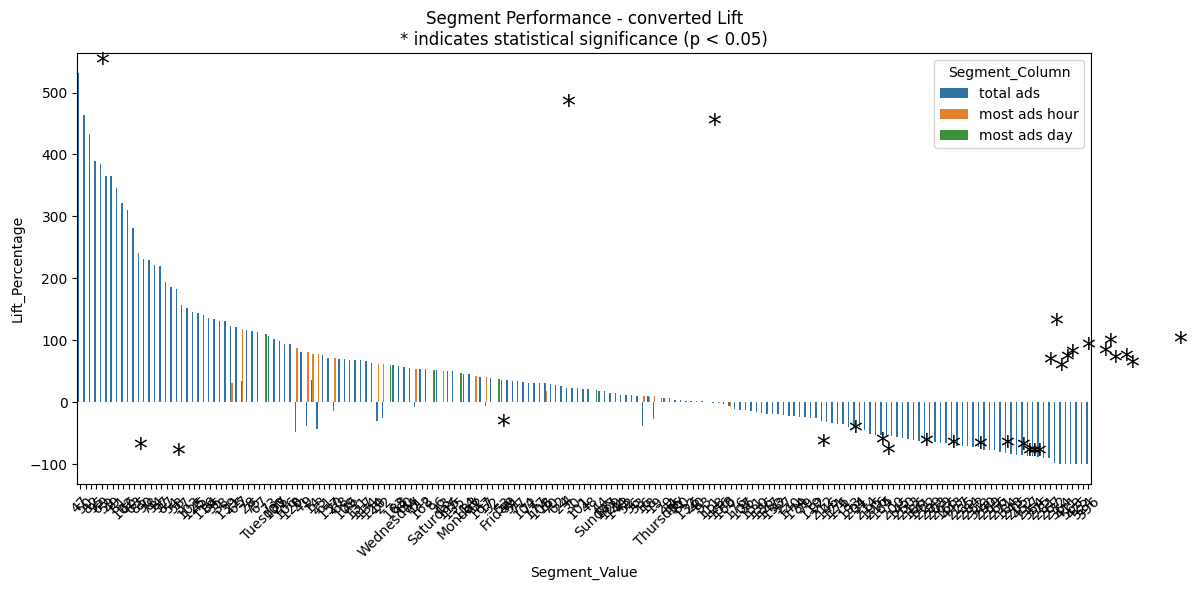

In [10]:
# Initialize and set up as before
analyzer = MarketingAnalyzer(data)
analyzer.set_analysis_columns(segment_columns=['total ads', 'most ads day', 'most ads hour'] ,
                            kpi_columns=['converted'])

# Get segment analysis with significance testing
segment_analysis = analyzer.analyze_segments('converted')
print("\nSegment Analysis with Significance Testing:")
print(segment_analysis[['Segment_Column', 'Segment_Value',
                       'Lift_Percentage', 'P_Value', 'Is_Significant']])

# Visualize with significance indicators
analyzer.plot_segment_performance('converted')

In [ ]:
# Calculate overall lift
overall_lift = analyzer.calculate_lift()
print("Overall Campaign Performance:")
print(overall_lift)

Overall Campaign Performance:
         KPI  Target_Mean  Control_Mean  Lift_Percentage  Z_Statistic  \
0  converted     0.025547      0.017854        43.085064     7.370078   

        P_Value  Is_Significant  
0  1.705303e-13            True  


In [11]:
# Classify customers into marketing groups
classified_data = analyzer.identify_marketing_groups(kpi='converted')
group_distribution = classified_data['Marketing_Group'].value_counts()
print("\nMarketing Group Distribution:")
print(group_distribution)

AttributeError: 'MarketingAnalyzer' object has no attribute 'identify_marketing_groups'